In [1]:
import torch
import torchvision
from torchvision import transforms
import digits_dataset

transform = torchvision.transforms.Compose(
    [
    transforms.Resize((28, 28)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True)

label_transform = lambda l: l
digit_trainset = digits_dataset.MnistWithPrintWriterLabels(trainset, 
                                            "./data/digits",
                                            digit_transform=transform,
                                                          label_transform=lambda l: label_transform(l))
digit_trainset_loader = torch.utils.data.DataLoader(digit_trainset, batch_size=5,
                                                    shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

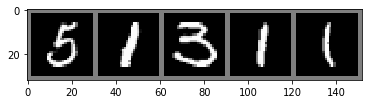

tensor(5) tensor(1) tensor(3) tensor(1) tensor(1)


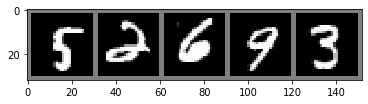

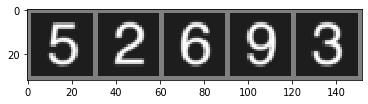

In [3]:
from util import imshow

images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(5)))

images, digits = iter(digit_trainset_loader).next()
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(digits))

In [4]:
from autoencoder import Net
net = Net()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
  (unclassifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


In [5]:
import torch.optim as optim
import torch.nn as nn
from trainer import train

# Train encoder
params = net.set_train_encoder()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(net, train_loader, optimizer, criterion, 1)

[1,  2000] loss: 1.346
[1,  4000] loss: 0.577
[1,  6000] loss: 0.425
[1,  8000] loss: 0.357
[1, 10000] loss: 0.338
[1, 12000] loss: 0.290
Finished Training


In [6]:
# Train decoder
# Important: Only pass those parameters to the optimizer that should get updated.
# The optimizer will change weights unless the gradient is 'None', i.e., the
# interaction between the optimizer and require_grad is not so obvious. Alternatively,
# we could set the encoder weights to None explicitly in Net::set_train_decoder,
# but that seems more of a hack.
# Compare https://github.com/pytorch/pytorch/blob/master/torch/optim/adam.py#L62
params = net.set_train_decoder()
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
train(net, digit_trainset_loader, optimizer, criterion, 1)

[1,  2000] loss: 0.094
[1,  4000] loss: 0.033
[1,  6000] loss: 0.028
[1,  8000] loss: 0.026
[1, 10000] loss: 0.025
[1, 12000] loss: 0.025
Finished Training


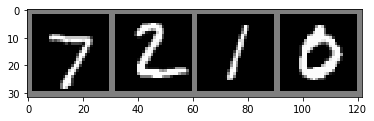

GroundTruth:  tensor(7) tensor(2) tensor(1) tensor(0)
Predicted:  tensor(7) tensor(2) tensor(1) tensor(0)


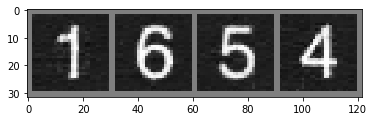

In [9]:
images, labels = iter(test_loader).next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(len(images))))

# Test encoder
net.set_eval_encoder()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(len(images))))

# Test decoder
net.set_eval_decoder()
outputs = net(images)
imshow(torchvision.utils.make_grid(outputs))


In [ ]:
label_transform = lambda l: (int(l) + 5) % 10
params = net.set_train_decoder()
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
train(net, digit_trainset_loader, optimizer, criterion, 1)

[1,  2000] loss: 0.053
[1,  4000] loss: 0.034
